In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
from yellowbrick.regressor import PredictionError
import smogn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor
from lightgbm import LGBMRegressor


In [3]:
pip install smogn lightgbm

Note: you may need to restart the kernel to use updated packages.


Importing processed data after EDA on book_rating_ML.ipynb

In [4]:
df = pd.read_csv("processed_data.csv",sep=",")

In [5]:
df.head()

,bookID,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,publisher,eng,others,publication_year
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,652,2095690,27591,Scholastic Inc.,1,0,2006
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,870,2153167,29221,Scholastic Inc.,1,0,2004
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,352,6333,244,Scholastic,1,0,2003
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,435,2339585,36325,Scholastic Inc.,1,0,2004
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,2690,41428,164,Scholastic,1,0,2004


BookID column contains inconsistent indexing, so we will remove it

In [6]:
df.drop(["bookID"],axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               11127 non-null  object 
 1   authors             11127 non-null  object 
 2   average_rating      11127 non-null  float64
 3   num_pages           11127 non-null  int64  
 4   ratings_count       11127 non-null  int64  
 5   text_reviews_count  11127 non-null  int64  
 6   publisher           11127 non-null  object 
 7   eng                 11127 non-null  int64  
 8   others              11127 non-null  int64  
 9   publication_year    11127 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 869.4+ KB


We will explore the relationships between variables

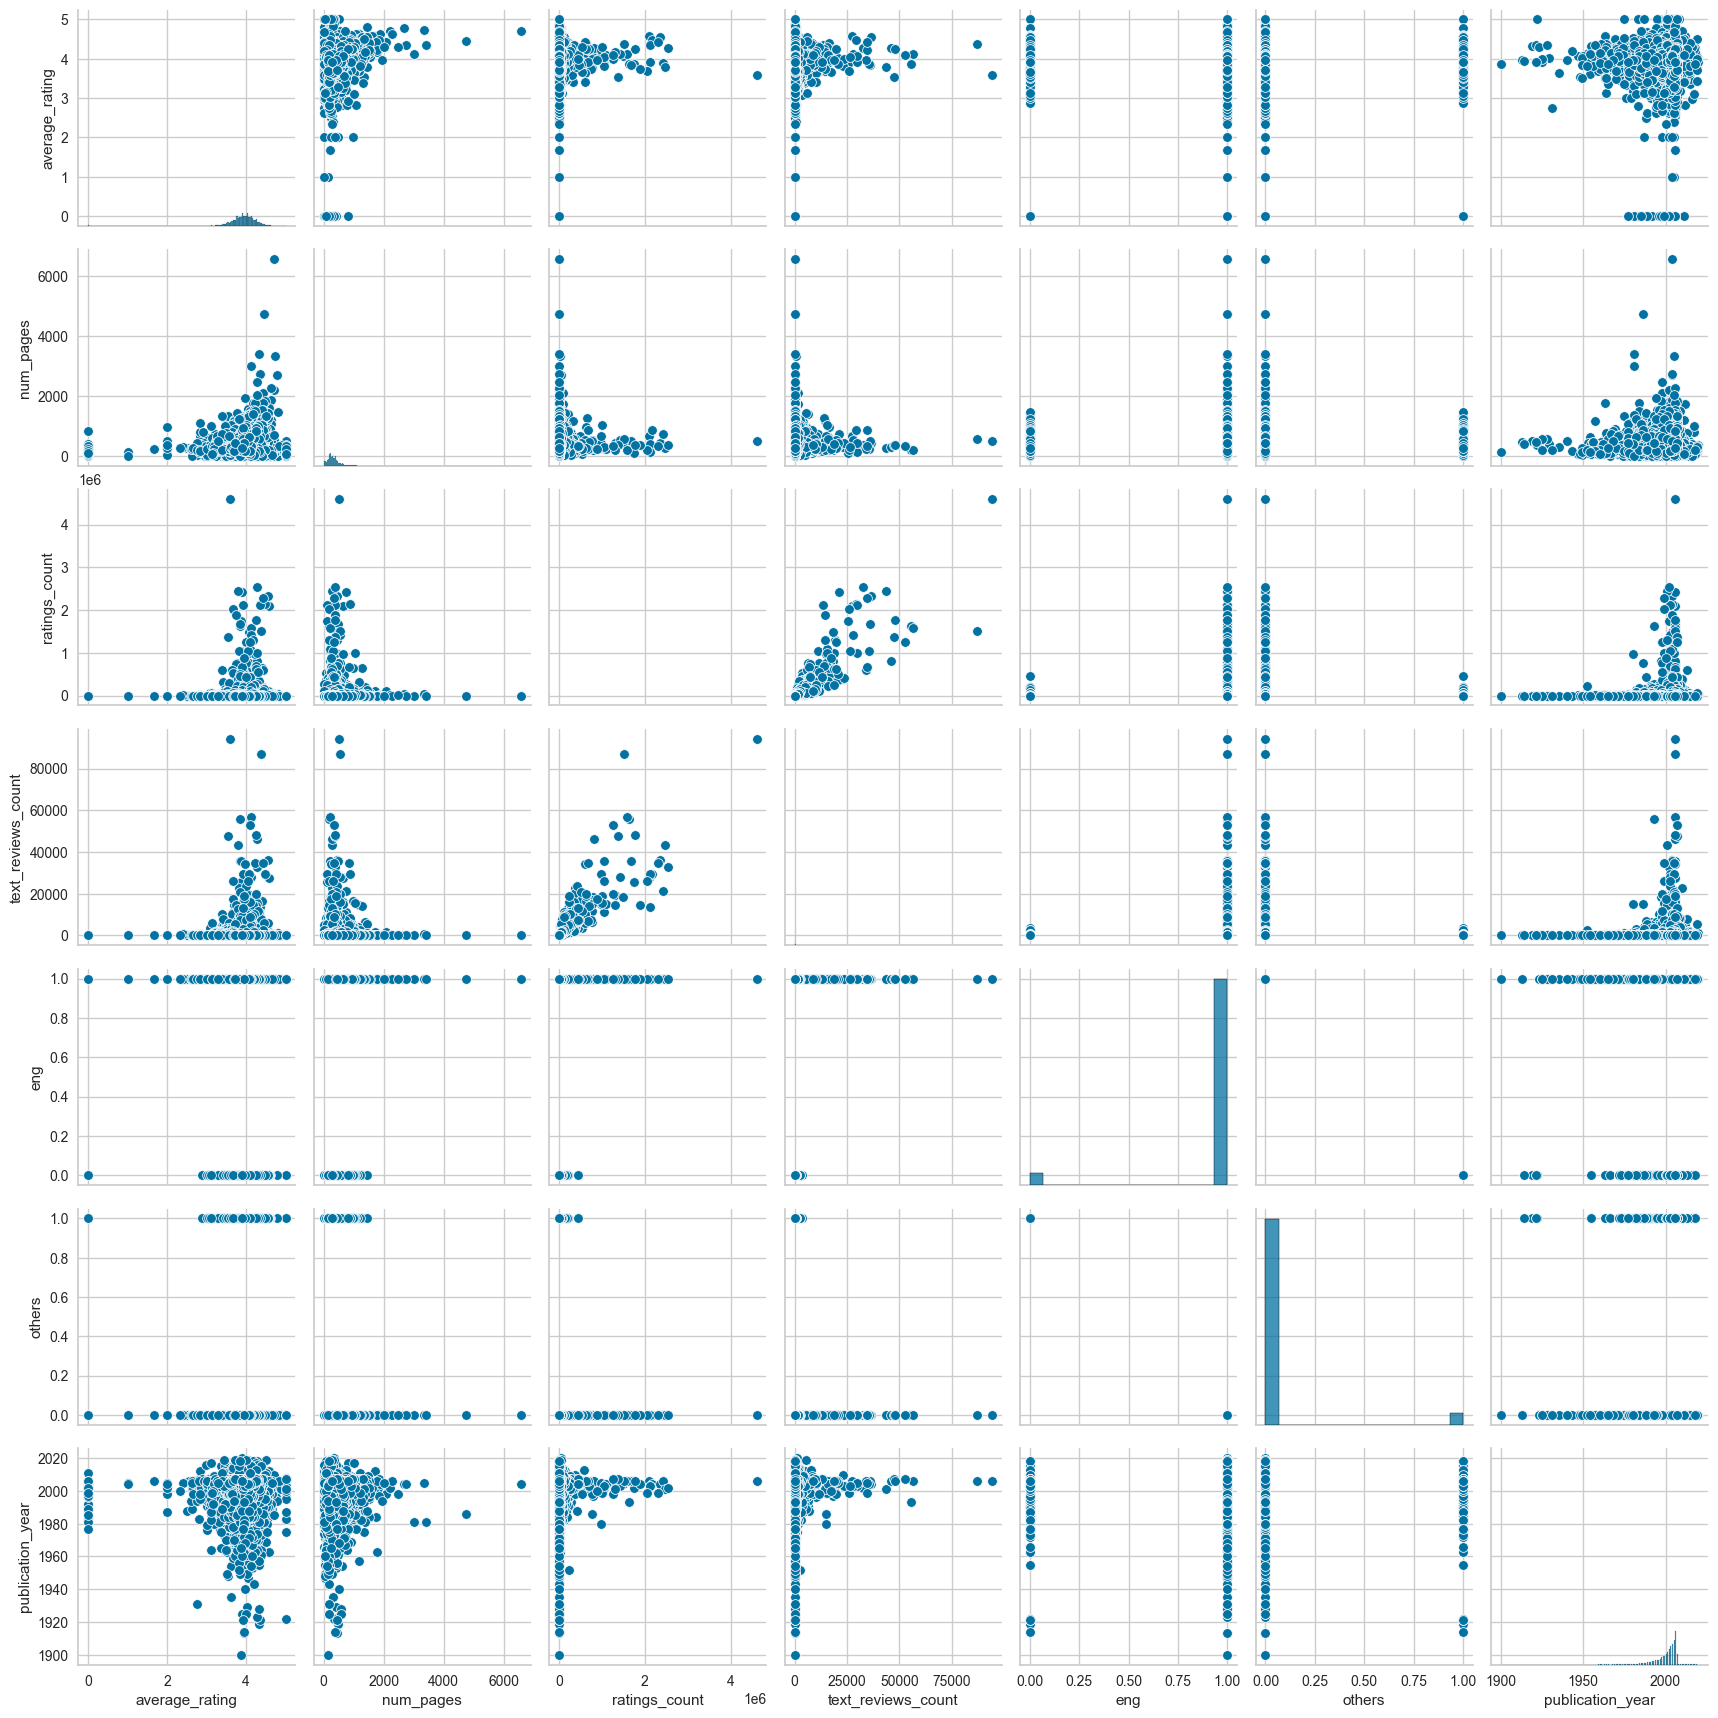

In [8]:
sns.pairplot(df)
plt.show()

Exploring insights from categorical variables. 

In [7]:
categoricalVars = ['title', 'authors', 'publisher']
df[categoricalVars].describe()

,title,authors,publisher
count,11127,11127,11127
unique,10352,6643,2292
top,The Brothers Karamazov,Stephen King,Vintage
freq,9,40,318


They are not categories and there're too many unique values so we will drop them.

In [8]:
df = df.drop(columns=['title', 'authors', 'publisher'])

In [9]:
#df['num_occ'] = df.groupby('title')['title'].transform('count') # Add a new feature which has the number of occurences of each book

Creating new features by multiplying the target to potential features.

In [10]:
#df['rate_occ'] = df['average_rating'] * df['num_occ']
df['rate_weight'] = df['average_rating'] * df['text_reviews_count']
df['rate_weight_2'] = df['average_rating'] * df['ratings_count']
df['rate_per_pages'] = df['average_rating'] * df['num_pages']

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   average_rating      11127 non-null  float64
 1   num_pages           11127 non-null  int64  
 2   ratings_count       11127 non-null  int64  
 3   text_reviews_count  11127 non-null  int64  
 4   eng                 11127 non-null  int64  
 5   others              11127 non-null  int64  
 6   publication_year    11127 non-null  int64  
 7   rate_weight         11127 non-null  float64
 8   rate_weight_2       11127 non-null  float64
 9   rate_per_pages      11127 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 869.4 KB


Check the correlations of the variables.

<module 'matplotlib.pyplot' from 'C:\\Users\\tanattiya\\anaconda3\\envs\\myenv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 500x500 with 0 Axes>

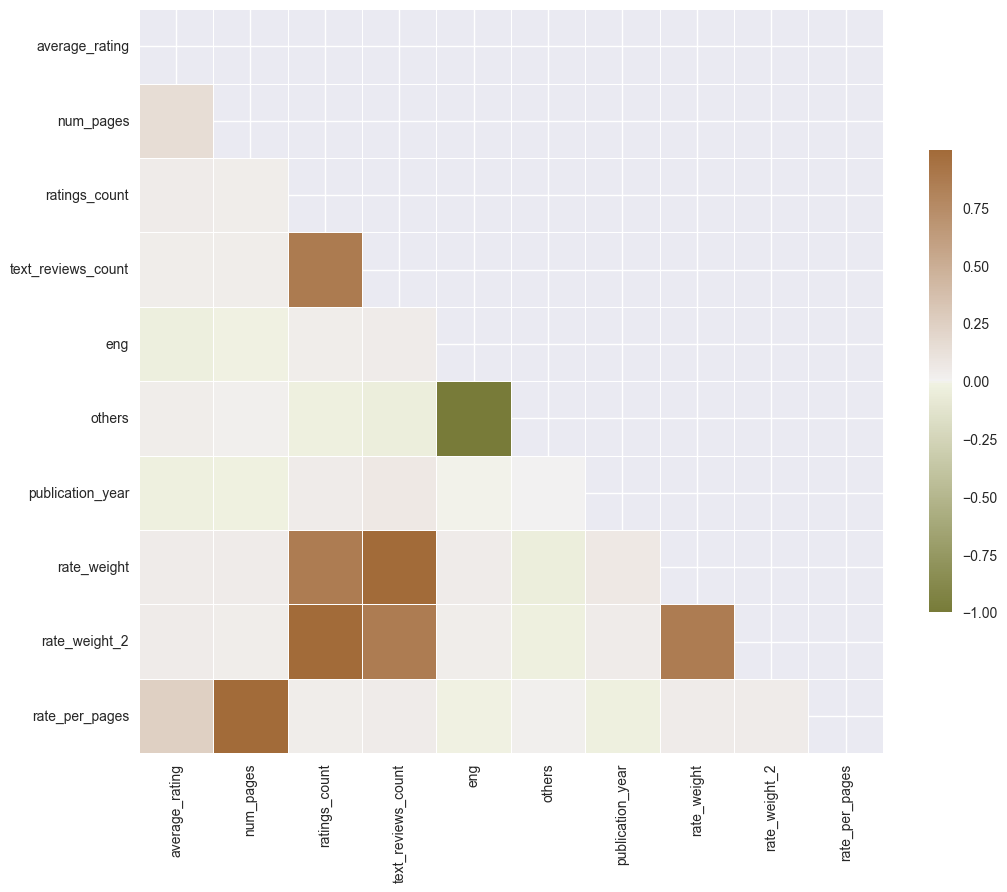

In [12]:
corr = df.corr()

plt.figure(figsize=(5,5))

# Exclude duplicate correlations by masking uper right values
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set background color / chart style
sns.set_style(style = 'darkgrid')

# Set up  matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Add diverging colormap
cmap = sns.diverging_palette(89, 400, as_cmap=True)

sns.heatmap(corr, mask = mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": .5}, ax=ax)

plt

In [13]:
# Separate features and target
X = df.drop(columns=['average_rating'])
y = df['average_rating']

# Display the first few rows of the dataset
df.head()

,average_rating,num_pages,ratings_count,text_reviews_count,eng,others,publication_year,rate_weight,rate_weight_2,rate_per_pages
0,4.57,652,2095690,27591,1,0,2006,126090.87,9577303.30,2979.64
1,4.49,870,2153167,29221,1,0,2004,131202.29,9667719.83,3906.30
2,4.42,352,6333,244,1,0,2003,1078.48,27991.86,1555.84
3,4.56,435,2339585,36325,1,0,2004,165642.00,10668507.60,1983.60
4,4.78,2690,41428,164,1,0,2004,783.92,198025.84,12858.20


In [14]:
X

,num_pages,ratings_count,text_reviews_count,eng,others,publication_year,rate_weight,rate_weight_2,rate_per_pages
0,652,2095690,27591,1,0,2006,126090.87,9577303.30,2979.64
1,870,2153167,29221,1,0,2004,131202.29,9667719.83,3906.30
2,352,6333,244,1,0,2003,1078.48,27991.86,1555.84
3,435,2339585,36325,1,0,2004,165642.00,10668507.60,1983.60
4,2690,41428,164,1,0,2004,783.92,198025.84,12858.20
...,...,...,...,...,...,...,...,...,...
11122,512,156,20,1,0,2004,81.20,633.36,2078.72
11123,635,783,56,1,0,1988,228.48,3194.64,2590.80
11124,415,820,95,1,0,1993,376.20,3247.20,1643.40
11125,434,769,139,1,0,2007,517.08,2860.68,1614.48


In [15]:
y

0       4.57
1       4.49
2       4.42
3       4.56
4       4.78
        ... 
11122   4.06
11123   4.08
11124   3.96
11125   3.72
11126   3.91
Name: average_rating, Length: 11127, dtype: float64

In [16]:
# Identify features to normalize
features_to_normalize = ['ratings_count', 'text_reviews_count']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the specific features
X[features_to_normalize] = scaler.fit_transform(X[features_to_normalize])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:

# Train a Random Forest Regressor
model_smogn = RandomForestRegressor()
model_smogn.fit(X_train, y_train)

# Make predictions
y_pred = model_smogn.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Evaluate the model
mse_smogn = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error model smogn: {mse_smogn}, \nmae: {mae}, \nr2:{r2}')




Mean Squared Error model smogn: 0.006399407789757418, 
mae: 0.029171338724168914, 
r2:0.9470938547561858


In [18]:
mse_smogn

np.float64(0.006399407789757418)

In [19]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [20]:
mae

np.float64(0.029171338724168914)

In [21]:
r2

0.9470938547561858

In [22]:
mae

np.float64(0.029171338724168914)

In [23]:
r2

0.9470938547561858

In [24]:
X_train.ndim, X_test.ndim, y_train.ndim, y_test.ndim

(2, 2, 1, 1)

In [25]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

models

 21%|█████████████████▏                                                              | 9/42 [00:03<00:14,  2.29it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


100%|███████████████████████████████████████████████████████████████████████████████| 42/42 [00:54<00:00,  1.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 8901, number of used features: 9
[LightGBM] [Info] Start training from score 3.932881


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.97,0.97,0.06,1.89
RandomForestRegressor,0.95,0.95,0.08,6.69
BaggingRegressor,0.93,0.93,0.09,0.67
LGBMRegressor,0.93,0.93,0.09,0.15
HistGradientBoostingRegressor,0.92,0.92,0.10,0.37
DecisionTreeRegressor,0.92,0.92,0.10,0.11
XGBRegressor,0.92,0.92,0.10,0.19
ExtraTreeRegressor,0.86,0.86,0.13,0.03
NuSVR,0.86,0.86,0.13,9.94


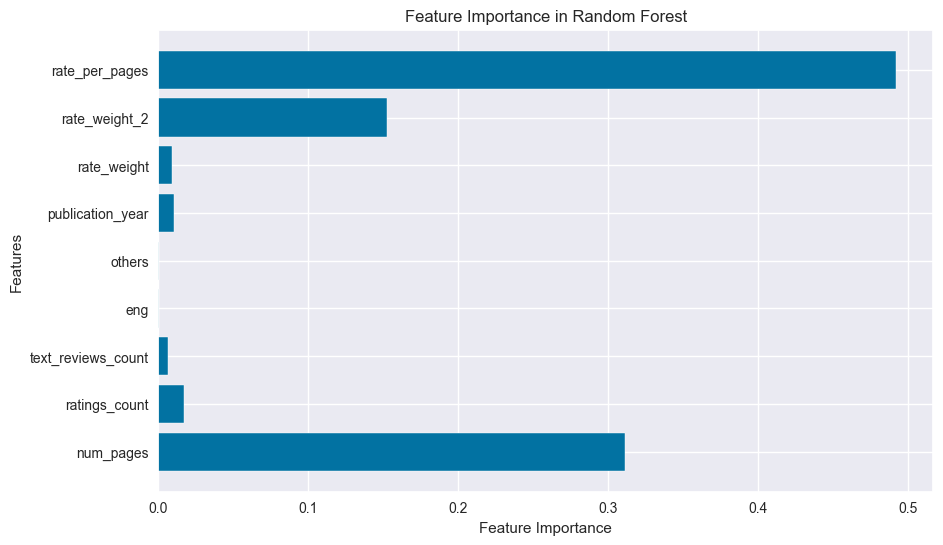

Mean Squared Error model smogn: 0.006522312758310878


In [26]:
best_rf = RandomForestRegressor(n_estimators=100, random_state=42)
best_rf.fit(X_train, y_train)

# Get feature importances
importance = best_rf.feature_importances_
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.show()

# Train a Random Forest Regressor
model_smogn = RandomForestRegressor()
model_smogn.fit(X_train, y_train)

# Make predictions
y_pred = model_smogn.predict(X_test)

# Evaluate the model
mse_smogn = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error model smogn: {mse_smogn}')

In [27]:
# Calculate and print additional metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse_smogn = np.sqrt(mse_smogn)
print(f'\nMean Absolute Error (MAE): {mae}')
print(f'R-squared: {r2}')
print(f'Root Mean Squared Error (RMSE):{rmse_smogn}')
print(f'Mean Squared Error (MSE): {mse_smogn}')


Mean Absolute Error (MAE): 0.02927735849056604
R-squared: 0.9460777563403474
Root Mean Squared Error (RMSE):0.08076083678560345
Mean Squared Error (MSE): 0.006522312758310878


In [28]:
comparison= pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residual': y_test - y_pred})

In [29]:
comparison

,Actual,Predicted,Residual
8663,3.92,3.91,0.01
483,3.97,3.96,0.01
8403,4.09,4.08,0.01
6382,4.02,4.02,0.00
1844,4.16,4.16,-0.00
...,...,...,...
2344,3.83,3.82,0.01
4099,3.84,3.84,0.00
5594,4.25,4.25,-0.00
4605,4.45,4.38,0.07


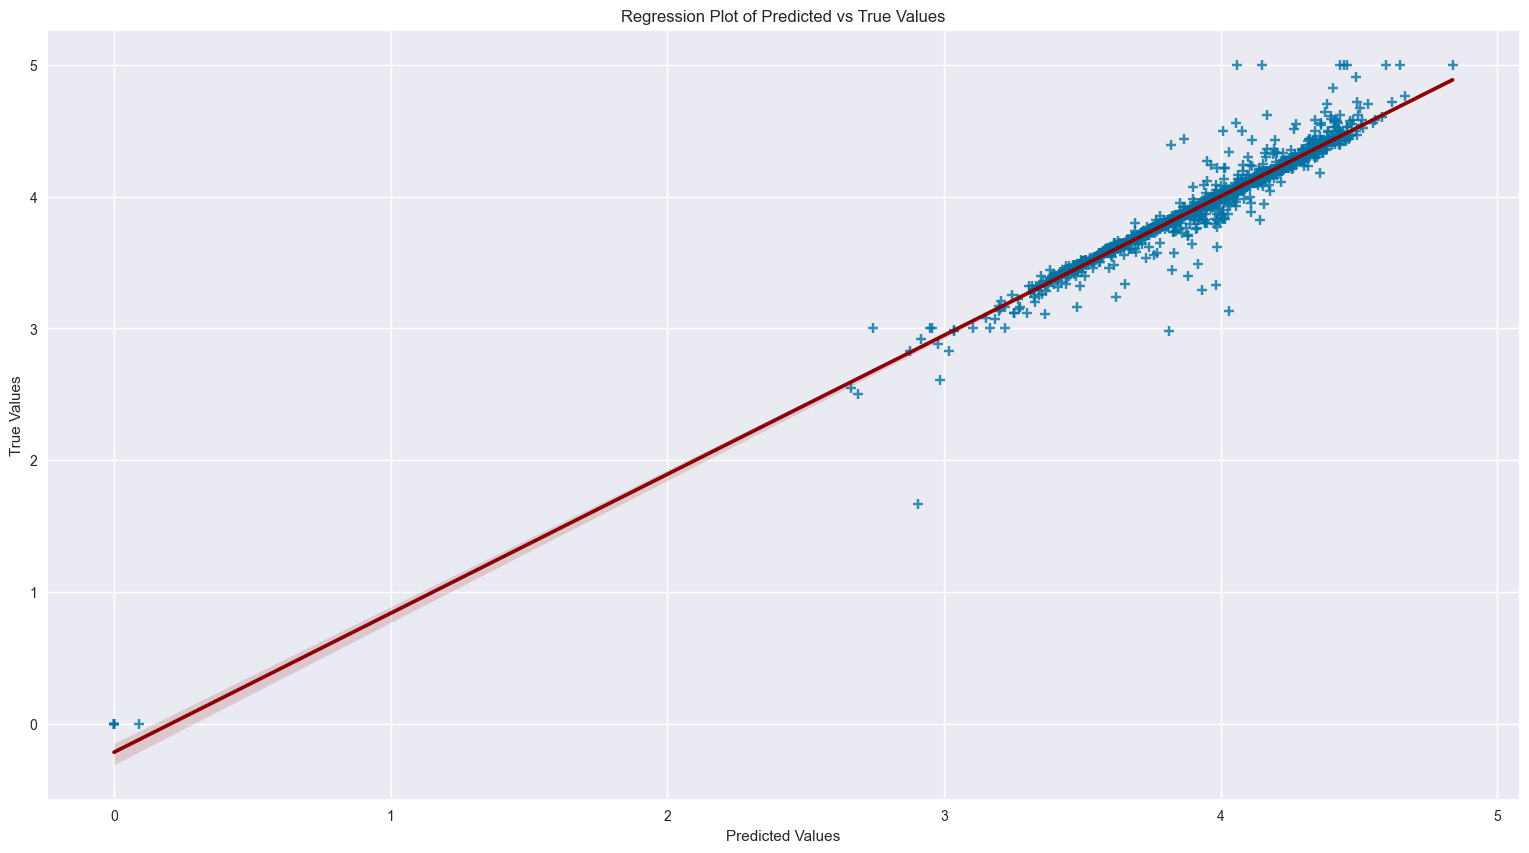

In [30]:
plt.figure(figsize=(19, 10))
sns.regplot(x=y_pred, y=y_test, marker="+", line_kws={'color':'darkred','alpha':1.0})
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Regression Plot of Predicted vs True Values')
plt.show()

LGBMRegressor model

In [31]:
# Separate features and target
X2 = df.drop(columns=['average_rating'])
y2 = df['average_rating']

# Identify features to normalize
features_to_normalize = ['ratings_count', 'text_reviews_count']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the specific features
X2[features_to_normalize] = scaler.fit_transform(X[features_to_normalize])

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)


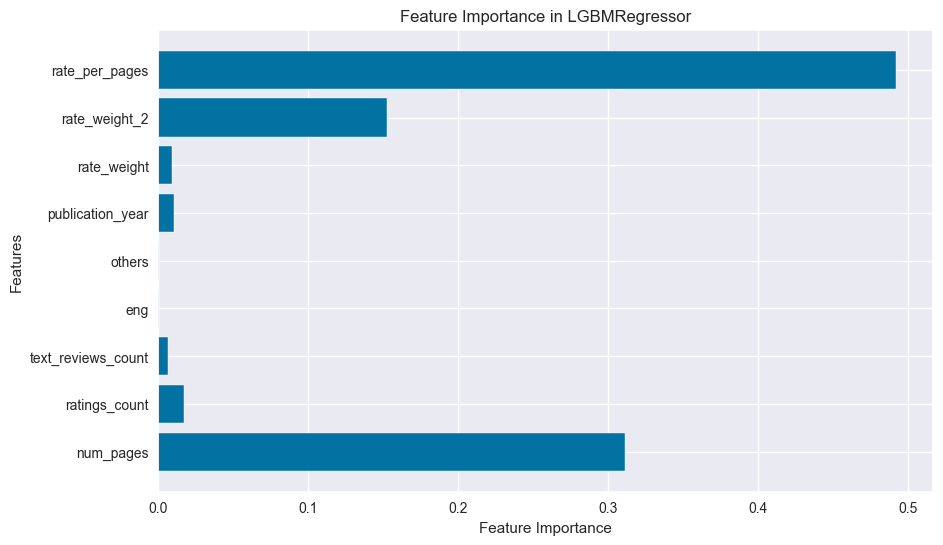

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1606
[LightGBM] [Info] Number of data points in the train set: 8901, number of used features: 9
[LightGBM] [Info] Start training from score 3.932881


In [32]:
# Get feature importances
importance = best_rf.feature_importances_
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in LGBMRegressor')
plt.show()

# Train a Random Forest Regressor
model_smogn = LGBMRegressor()
model_smogn.fit(X_train, y_train)

# Make predictions
y_pred2 = model_smogn.predict(X_test)



In [33]:
# Calculate and print additional metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse_smogn = np.sqrt(mse_smogn)
print(f'\nMean Absolute Error (MAE): {mae}')
print(f'R-squared: {r2}')
print(f'Root Mean Squared Error (RMSE):{rmse_smogn}')
print(f'Mean Squared Error (MSE): {mse_smogn}')


Mean Absolute Error (MAE): 0.02927735849056604
R-squared: 0.9460777563403474
Root Mean Squared Error (RMSE):0.08076083678560345
Mean Squared Error (MSE): 0.006522312758310878


In [34]:
comparison= pd.DataFrame({'Actual': y_test2, 'Predicted': y_pred2, 'Residual': y_test2 - y_pred2})

In [35]:
comparison.head()

,Actual,Predicted,Residual
8663,3.92,3.88,0.04
483,3.97,3.97,0.00
8403,4.09,4.07,0.02
6382,4.02,4.04,-0.02
1844,4.16,4.14,0.02


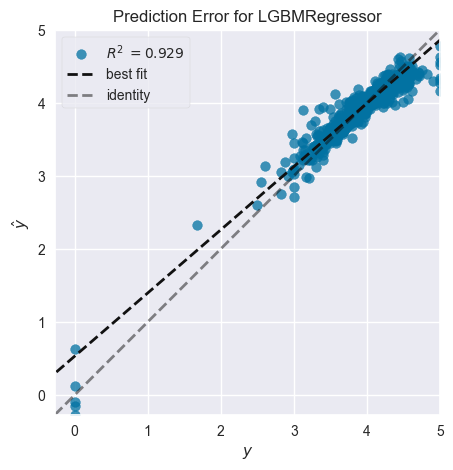

In [36]:
fig = plt.figure(figsize=(5, 5))
viz = PredictionError(model_smogn)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();

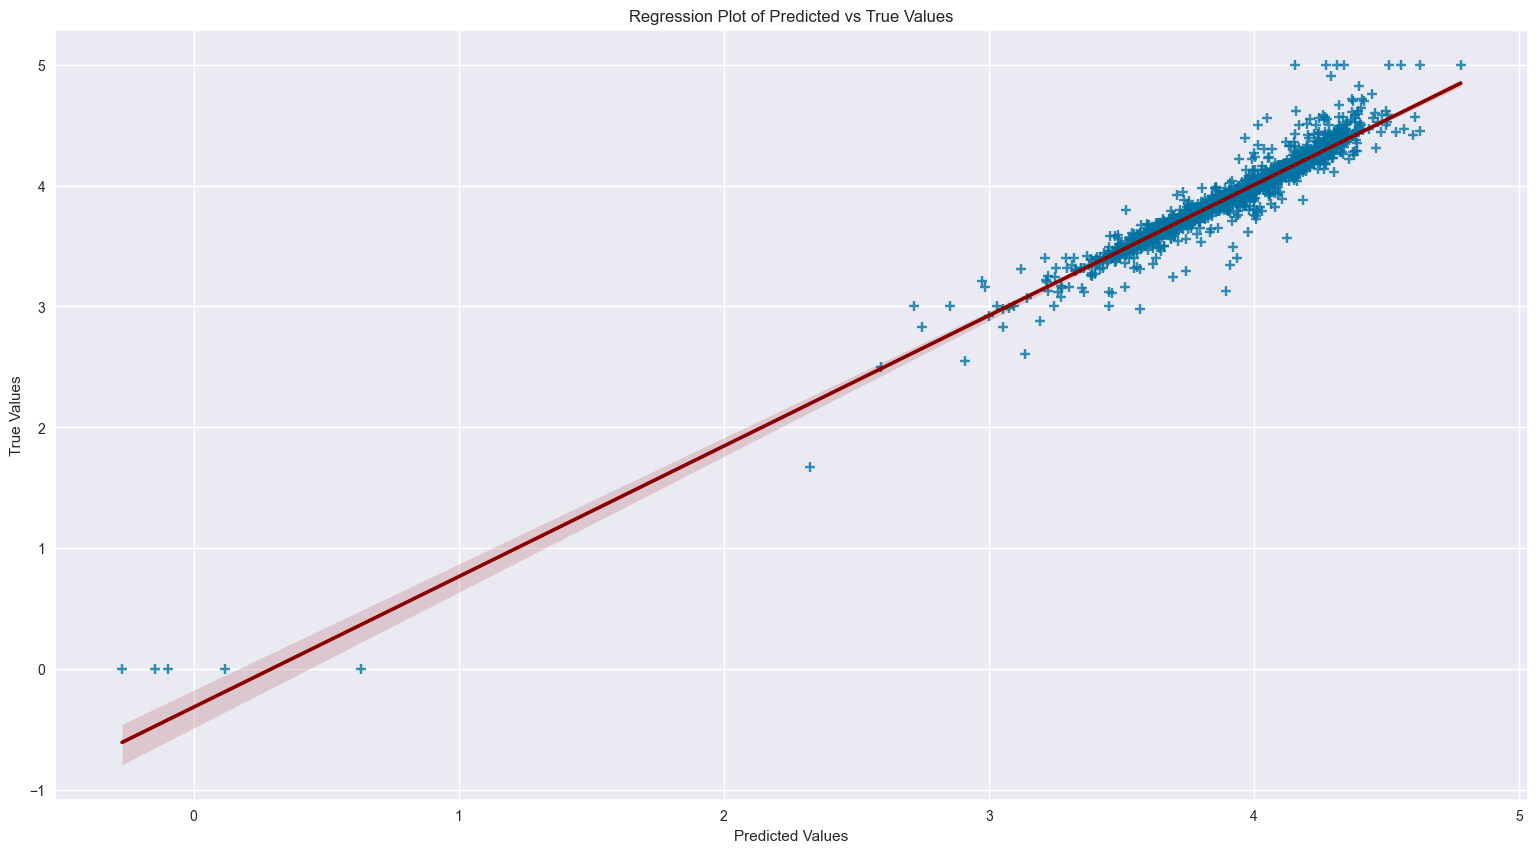

In [37]:
plt.figure(figsize=(19, 10))
sns.regplot(x=y_pred2, y=y_test2, marker="+", line_kws={'color':'darkred','alpha':1.0})
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Regression Plot of Predicted vs True Values')
plt.show()

In [38]:
model = GradientBoostingRegressor()

parameters = {
    'learning_rate': [0.001, 0.01, 0.02, 0.1, 0.2, 1.0],
    'n_estimators': [10, 50, 100, 200]
}

grad_Gra = GridSearchCV(model, parameters, refit=True)
grad_Gra.fit(X_train, y_train)

print('Best Score: ', grad_Gra.best_score_*100, '\nBest Parameters: ', grad_Gra.best_params_)

Best Score:  91.86371726542497 
Best Parameters:  {'learning_rate': 0.2, 'n_estimators': 200}


Mean Squared Error (MSE): 0.0053457791474073296
Root Mean Squared Error (RMSE): 0.07311483534418531
Mean Absolute Error (MAE): 0.04091247094751451
R^2 Score: 0.9558045717188455


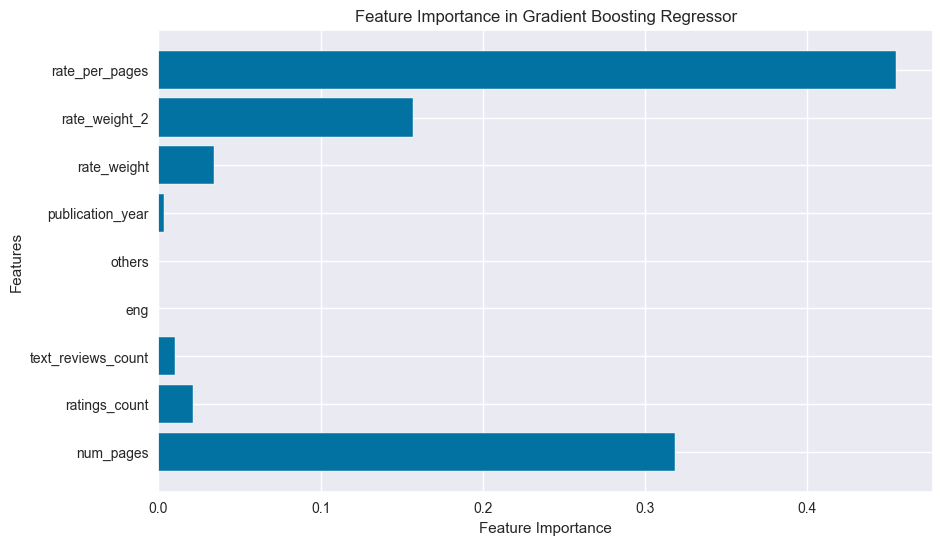

In [39]:
# Refit the model on the entire training dataset using the best parameters
best_model = GradientBoostingRegressor(learning_rate=grad_Gra.best_params_['learning_rate'],
                                       n_estimators=grad_Gra.best_params_['n_estimators'],
                                       max_depth=4)  # Assuming max_depth was part of the grid search
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R^2 Score: {r2}')

# Feature importance
import matplotlib.pyplot as plt

feature_importances = best_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Gradient Boosting Regressor')
plt.show()


In [40]:
# Initialize the models
models = {
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'BaggingRegressor': BaggingRegressor(estimator=RandomForestRegressor(), n_estimators=10),
    'LGBMRegressor': LGBMRegressor()
}

# Train and evaluate each model
for name, model in models.items():
    print(f'\n{name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')



ExtraTreesRegressor
Mean Squared Error (MSE): 0.004171516513926328
Root Mean Squared Error (RMSE): 0.06458727826690275
Mean Absolute Error (MAE): 0.020045822102425902
R^2 Score: 0.9655126121317045

RandomForestRegressor
Mean Squared Error (MSE): 0.006471309384546279
Root Mean Squared Error (RMSE): 0.08044444905987161
Mean Absolute Error (MAE): 0.02984766397124884
R^2 Score: 0.946499419092428

BaggingRegressor
Mean Squared Error (MSE): 0.008534100702380957
Root Mean Squared Error (RMSE): 0.09238019648377545
Mean Absolute Error (MAE): 0.0379686118598383
R^2 Score: 0.9294456008869816

LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1606
[LightGBM] [Info] Number of data points in the train set: 8901, number of used features: 9
[LightGBM] [Info] Start training from score 3.932881
Mean Squared Error (MSE): 0.008564683368716092
Root Mean


ExtraTreesRegressor
Mean Squared Error (MSE): 0.003993474514824799
Root Mean Squared Error (RMSE): 0.06319394365621439
Mean Absolute Error (MAE): 0.01948369272237202
R^2 Score: 0.9669845476878416


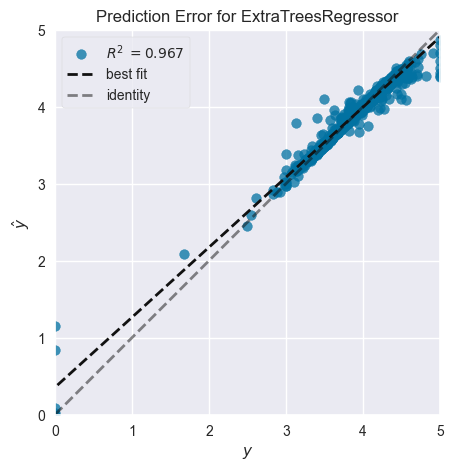

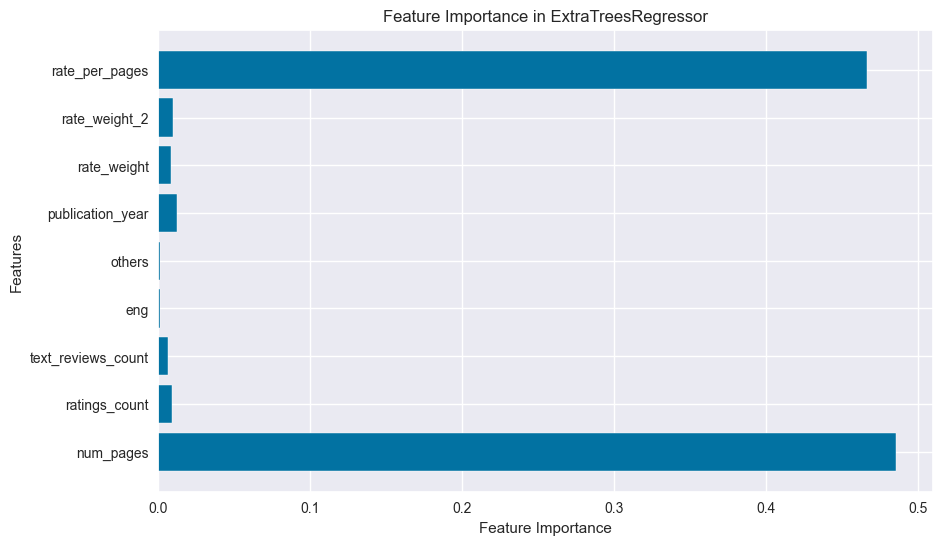


RandomForestRegressor
Mean Squared Error (MSE): 0.006587413755615464
Root Mean Squared Error (RMSE): 0.08116288410114234
Mean Absolute Error (MAE): 0.029139712488769044
R^2 Score: 0.945539543597533


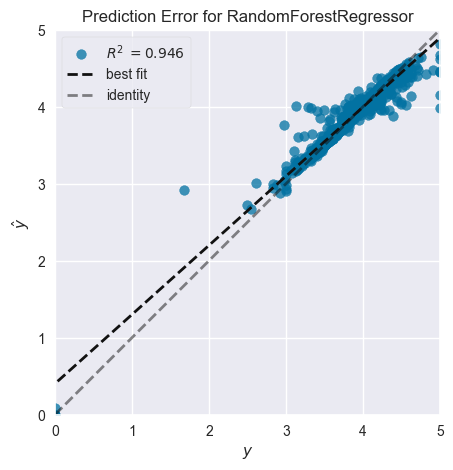

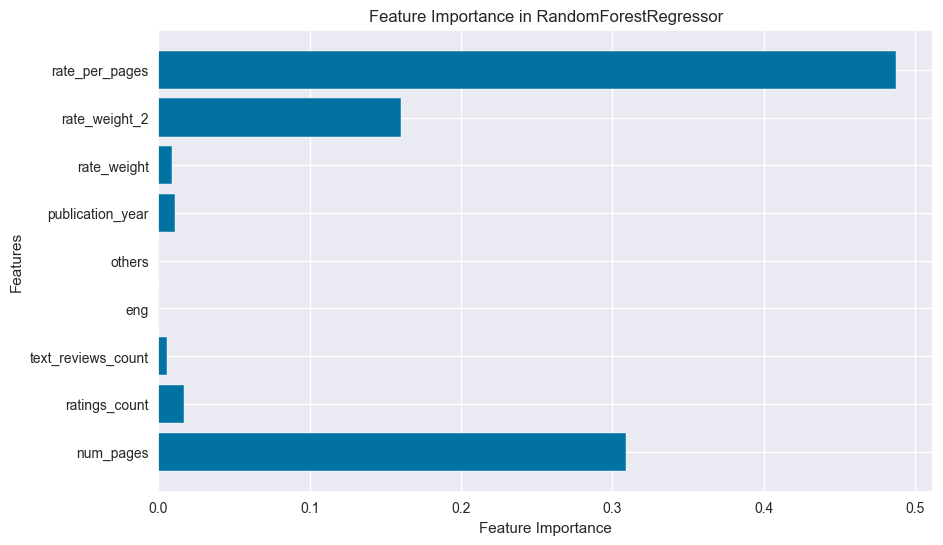


BaggingRegressor
Mean Squared Error (MSE): 0.008723643165633423
Root Mean Squared Error (RMSE): 0.09340044521110927
Mean Absolute Error (MAE): 0.03721744384546273
R^2 Score: 0.9278785869662942


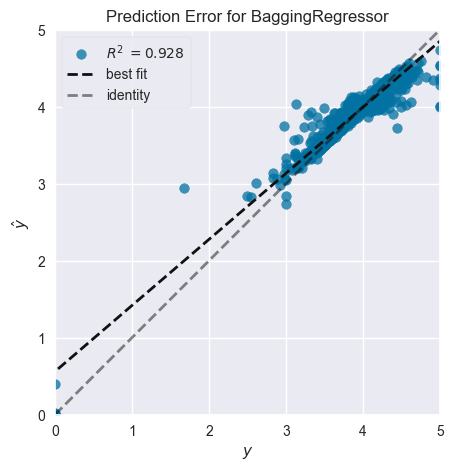


LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1606
[LightGBM] [Info] Number of data points in the train set: 8901, number of used features: 9
[LightGBM] [Info] Start training from score 3.932881
Mean Squared Error (MSE): 0.008564683368716092
Root Mean Squared Error (RMSE): 0.09254557454960281
Mean Absolute Error (MAE): 0.05113314766517692
R^2 Score: 0.929192763274467


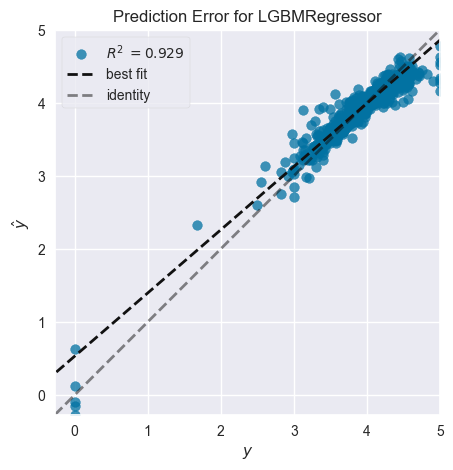

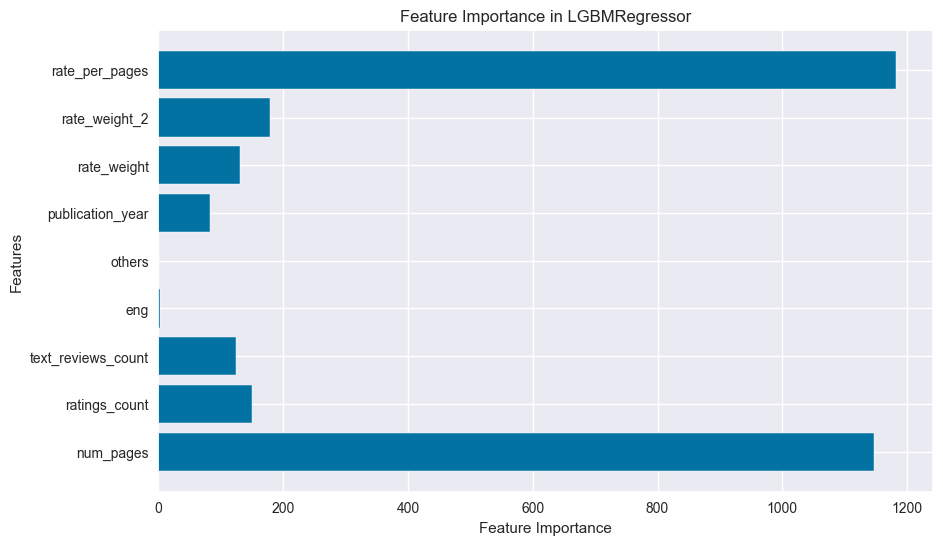

In [43]:
# Train, evaluate, and visualize each model
for name, model in models.items():
    print(f'\n{name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')
    
    # Visualize prediction error
    fig = plt.figure(figsize=(5, 5))
    viz = PredictionError(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()


    # Plot feature importance if available
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        features = X_train.columns

        plt.figure(figsize=(10, 6))
        plt.barh(features, feature_importances)
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title(f'Feature Importance in {name}')
        plt.show()
